<a href="https://colab.research.google.com/github/iqrakhan310/CODSOFT-DS-PROJECTS-/blob/main/SALES_FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OVERVIEW:


IMPORTING LIBRARARIES

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

In [ ]:
#LOADING DATASET

sales_data = pd.read_csv("store_sales.csv")

sales_data.head()


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


DATA PREPROCESSING

In [ ]:
#checking null values
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    57967 non-null  object
 1   store   57967 non-null  int64 
 2   item    57967 non-null  int64 
 3   sales   57967 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ MB


In [ ]:
#dropping unnecessary columns
sales_data=sales_data.drop(['store','item'] , axis=1)
sales_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    57967 non-null  object
 1   sales   57967 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 905.9+ KB


In [ ]:
#converting date datatype
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    57967 non-null  datetime64[ns]
 1   sales   57967 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 905.9 KB


In [ ]:
sales_data

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
...,...,...
57962,2016-09-18,51
57963,2016-09-19,23
57964,2016-09-20,32
57965,2016-09-21,20


In [ ]:

# Convert 'Date' to a period (if needed)
sales_data['date'] = sales_data['date'].dt.to_period("M")

# Group by 'Date' and sum 'ItemsSold'
monthly_sales = sales_data.groupby('date').sum().reset_index()

# Convert 'Date' back to a timestamp (if needed)
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

print(monthly_sales)


AttributeError: ignored

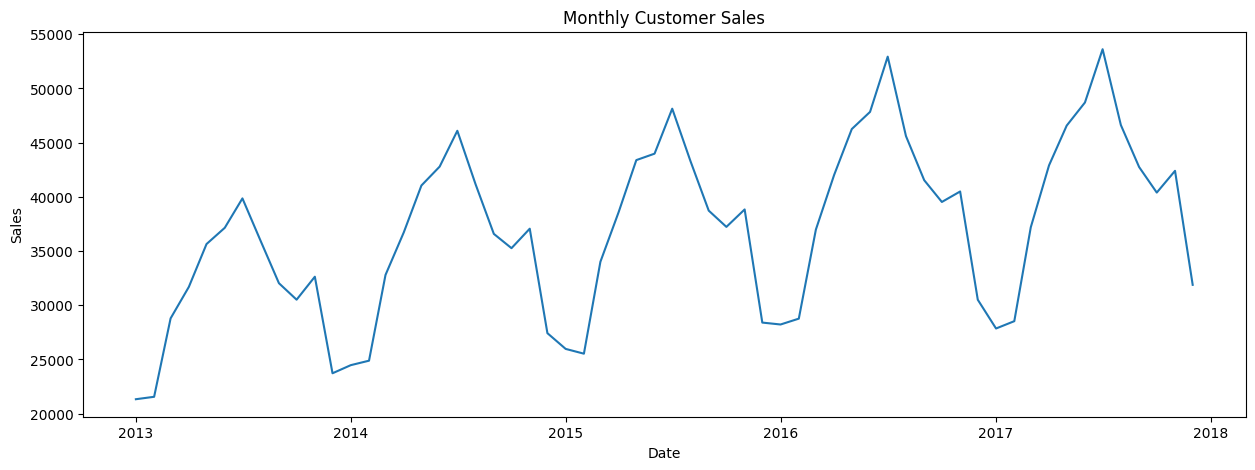

In [ ]:
#DATA VISUALIZATION

plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()


In [ ]:
#call the difference on sales column to make sales stationery
monthly_sales['sales_difference']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(15)

,date,sales,sales_difference
1,2013-02-01,21556,224.0
2,2013-03-01,28791,7235.0
3,2013-04-01,31696,2905.0
4,2013-05-01,35647,3951.0
5,2013-06-01,37147,1500.0
6,2013-07-01,39860,2713.0
7,2013-08-01,35927,-3933.0
8,2013-09-01,32035,-3892.0
9,2013-10-01,30515,-1520.0
10,2013-11-01,32634,2119.0


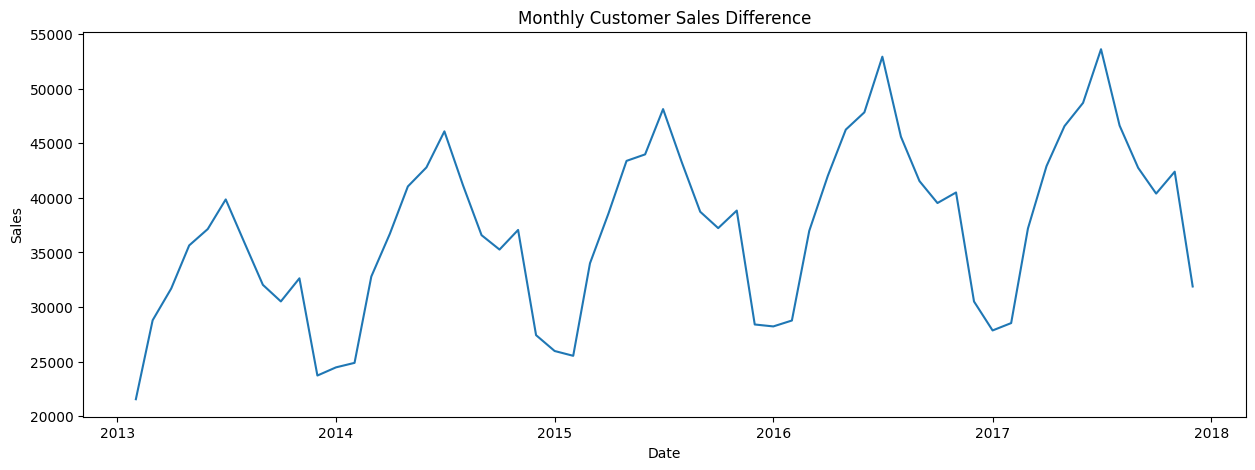

In [ ]:
#visualize sales difference

plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

In [ ]:
#dropping off sales and date
supervised_data=monthly_sales.drop(['date','sales'] ,axis=1)

#preparing supervised data
#prev 12 months sales=input feature
#next 12 months sales=output feature

for i in range(1,13):
    col_name="Monthly_" + str(i)
    supervised_data[col_name]=supervised_data['sales_difference'].shift(i)

supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(15)


,sales_difference,Monthly_1,Monthly_2,Monthly_3,Monthly_4,Monthly_5,Monthly_6,Monthly_7,Monthly_8,Monthly_9,Monthly_10,Monthly_11,Monthly_12
0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0,7235.0,224.0
1,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0,7235.0
2,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0
3,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0
4,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0
5,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0
6,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0
7,-4575.0,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0
8,-1319.0,-4575.0,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0
9,1797.0,-1319.0,-4575.0,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0


In [ ]:
#splitting data as train and test
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train data shape",train_data.shape)
print("Test data shape",test_data.shape)


Train data shape (35, 13)
Test data shape (12, 13)


In [ ]:

#scale th feature values to restrict them to range -1 and 1 (scalling data)
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)


In [ ]:
#1st column=output , remaining+input features
x_train, y_train=train_data[:,1:] , train_data[:,0:1]
x_test, y_test=test_data[:,1:] , test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("x_train Shape:", x_train.shape)
print("y_train Shape:", y_train.shape)
print("x_test Shape:", x_test.shape)
print("y_test Shape:", y_test.shape)

x_train Shape: (35, 12)
y_train Shape: (35,)
x_test Shape: (12, 12)
y_test Shape: (12,)


In [ ]:

#make prediction dataframe to merge the predicted sales prices of all trained algos
sales_dates= monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)


In [ ]:
actual_sales=monthly_sales['date'][-13:].to_list()
print(actual_sales)

[Timestamp('2016-12-01 00:00:00'), Timestamp('2017-01-01 00:00:00'), Timestamp('2017-02-01 00:00:00'), Timestamp('2017-03-01 00:00:00'), Timestamp('2017-04-01 00:00:00'), Timestamp('2017-05-01 00:00:00'), Timestamp('2017-06-01 00:00:00'), Timestamp('2017-07-01 00:00:00'), Timestamp('2017-08-01 00:00:00'), Timestamp('2017-09-01 00:00:00'), Timestamp('2017-10-01 00:00:00'), Timestamp('2017-11-01 00:00:00'), Timestamp('2017-12-01 00:00:00')]


In [ ]:
#to create LGM & predicted output
LR_model= LinearRegression()
LR_model.fit(x_train,y_train)
LR_prediction=LR_model.predict(x_test)


LR_prediction=LR_prediction.reshape(-1,1)

In [ ]:
#set matrix-contains input features and test data
#also contains predicted output+ actual_sales[index]LR_prediction_series=pd.Series(result_list,name="Linear Prediction")


LR_prediction_test_set=np.concatenate([LR_prediction,x_test], axis=1)
LR_prediction_test_set=scaler.inverse.transform(LR_prediction_test_set)

result_list=[]
for index in range(0,len(LR_prediction_test_set)):
    result_list.append(LR_prediction_test_set[index][0]+ actual_sales[index])

LR_prediction_series=pd.Series(result_list,name="Linear Prediction")
predict_df=predict_df.merge(LR_prediction_series, left_index=True, right_index=True)
print(predict_df)




NameError: ignored

In [ ]:
LR_MSE= np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
print("Linear Regression MSE:", LR_MSE)

LR_MAE= mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print("Linear Regression MSE:", LR_MAE)
LR_R2= r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print("Linear Regression MSE:", LR_R2)

In [ ]:
#visualizing prediction against actual sales
plt.figure(figsize=(15,5))
#actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])

#predicted sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Customer Sales Forecast using LR Model")
plt.legent(['Actual sales', 'Predicted Sales'])
plt.show()